#### **Data Acquisation**

This notebook leverages the [NSCLC-Radiomics dataset](https://www.cancerimagingarchive.net/collection/nsclc-radiomics/) to develop a deep learning model for lung cancer stage prediction. 

The dataset provides pre-treatment CT scans from 422 NSCLC patients and expert-annotated  tumor segmentations enabling the training of a model to predict lung cancer stage directly from imaging data.

**Imports**

In [1]:
# Standard imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom  
from scipy import ndimage
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from Data_understanding import (load_csv_labels, load_ct_scan_from_slices, load_and_stack_ct_slices, find_patient_data_paths)

# Import our new CT preprocessing module
from ct_preprocessing import (preprocess_ct_scan, visualize_preprocessing, 
                             resample_volume, normalize_hu_values, resize_volume, 
                             center_crop_or_pad, enhance_contrast, apply_lung_window,
                             load_dicom_series_safely, preprocess_dicom_directory)

# Import our new CT data augmentation module
from ct_augmentation import (augment_ct_scan, visualize_augmentation_effects, create_augmented_batch, visualize_augmentations,
                            random_rotation_3d, random_shift_3d, random_flip_3d, random_zoom_3d,
                            random_noise_3d, random_gamma_3d, random_contrast_3d, elastic_deformation_3d)

# Import modules from the train_3d_resnet.py file
from train_3d_resnet import (
    set_seed, BasicBlock3D, ResNet3D, ResNet18_3D, CTScanDataset,
    train_model, evaluate_model, plot_training_history, plot_confusion_matrix
)

#### **CT Scan and Mask Alignment**

Before we can proceed with data preprocessing and augmentation, we need to ensure that our CT scans and segmentation masks are properly aligned. This section demonstrates how to align DICOM CT scans (stored as folders of 2D slices) with segmentation masks (stored as single DICOM files).

In [2]:
# Set base path and patient
base_dir = "E:/cancer stage/NSCLC-Radiomics"
patient_id = "LUNG1-078"
csv_path = "E:/cancer stage/lung_csv.csv"

# Find paths
ct_dir, mask_path = find_patient_data_paths(base_dir, patient_id)

# Output directory for aligned data
output_dir = "aligned_data"

# Check if CT and mask exist
if ct_dir and os.path.exists(ct_dir):
    print(f"CT directory exists: {ct_dir}")
    
    # Load and sort CT slices
    dicom_files = [f for f in os.listdir(ct_dir) if f.endswith('.dcm')]
    ct_paths = [os.path.join(ct_dir, f) for f in dicom_files]
    ct_slices = [pydicom.dcmread(f) for f in ct_paths]

    # Sort CT slices by Z-position if available
    ct_slices.sort(key=lambda x: float(x.ImagePositionPatient[2]) if 'ImagePositionPatient' in x else 0)

    print(f"Found {len(ct_slices)} CT slices.")
else:
    print(f"Error: CT directory not found or invalid.")

if mask_path and os.path.exists(mask_path):
    print(f"Segmentation mask exists: {mask_path}")

    # Load mask
    mask = pydicom.dcmread(mask_path)
    mask_data = mask.pixel_array
    print(f"Mask shape: {mask_data.shape}")

    # Number of slices in mask
    num_mask_slices = mask_data.shape[0]

    # Compare
    num_ct_slices = len(ct_slices)
    print(f"\nCT slices: {num_ct_slices}")
    print(f"Mask slices: {num_mask_slices}")

    if num_ct_slices == num_mask_slices:
        print("✅ Mask and CT have the same number of slices.")
    else:
        print(f"⚠️ Mismatch: Mask has {num_mask_slices} slices, CT has {num_ct_slices} slices.")

else:
    print(f"Error: Segmentation mask not found or invalid.")
    
z_positions = [float(slice.ImagePositionPatient[2]) for slice in ct_slices if 'ImagePositionPatient' in slice]
print(f"CT Z range: {min(z_positions)} to {max(z_positions)}")

CT directory exists: E:/cancer stage/NSCLC-Radiomics\LUNG1-078\01-01-2014-StudyID-NA-61542\1.000000-NA-52532
Found 136 CT slices.
Segmentation mask exists: E:/cancer stage/NSCLC-Radiomics\LUNG1-078\01-01-2014-StudyID-NA-61542\300.000000-Segmentation-20.89\1-1.dcm
Mask shape: (816, 512, 512)

CT slices: 136
Mask slices: 816
⚠️ Mismatch: Mask has 816 slices, CT has 136 slices.
CT Z range: -687.0 to -282.0


In [3]:
# --- 1. Get CT Z-positions ---
ct_z_positions = [float(ds.ImagePositionPatient[2]) for ds in ct_slices if 'ImagePositionPatient' in ds]
print(f"CT Z range: {min(ct_z_positions)} to {max(ct_z_positions)}")

# --- 2. Get Mask Z-positions ---
mask_z_positions = []
for item in mask.PerFrameFunctionalGroupsSequence:
    img_pos = item.PlanePositionSequence[0].ImagePositionPatient
    z = float(img_pos[2])
    mask_z_positions.append(z)

print(f"Mask Z range: {min(mask_z_positions)} to {max(mask_z_positions)}")

# --- 3. Match CT slices to Mask slices ---
# Build a mapping: for each CT slice, find the closest mask slice by Z
import numpy as np

mask_data = mask.pixel_array

aligned_mask_slices = []

for ct_z in ct_z_positions:
    # Find index of closest mask slice
    mask_idx = np.argmin(np.abs(np.array(mask_z_positions) - ct_z))
    aligned_mask_slices.append(mask_data[mask_idx])

aligned_mask = np.stack(aligned_mask_slices)

print(f"Aligned mask shape: {aligned_mask.shape}")

CT Z range: -687.0 to -282.0
Mask Z range: -687.0 to -282.0
Aligned mask shape: (136, 512, 512)


In [4]:
# Load CT scan using our custom function
ct_scan, dicom_datasets, metadata = load_and_stack_ct_slices(ct_dir)

# Display CT scan information
print("\nCT Scan Information:")
print(f"Shape: {ct_scan.shape}")
print(f"Data type: {ct_scan.dtype}")
print(f"Value range: [{ct_scan.min()}, {ct_scan.max()}]")
print(f"Spacing (z, y, x): {metadata[2]} mm")

Loading CT scan slices from E:/cancer stage/NSCLC-Radiomics\LUNG1-078\01-01-2014-StudyID-NA-61542\1.000000-NA-52532...
Found 136 DICOM slices
Sorting slices by ImagePositionPatient...
Reading DICOM slices...


100%|██████████| 136/136 [00:00<00:00, 565.92it/s]


Stacking slices...
Applied rescale: slope=1, intercept=0
Spacing (z, y, x): ('3.00000', '0.9770', '0.9770') mm
CT scan loaded with shape (136, 512, 512)

CT Scan Information:
Shape: (136, 512, 512)
Data type: float64
Value range: [-1024.0, 3071.0]
Spacing (z, y, x): 0.9770 mm


## **CT Scan Preprocessing**

In this section, we'll preprocess the CT scan, This includes:

1. **Resampling** to uniform voxel spacing
2. **Normalizing** HU values to a standard range
3. **Resizing** to a standard volume size
4. **Contrast enhancement** 
5. **Windowing** for better visualization 

In [5]:
# Extract spacing from metadata
original_spacing = metadata[2]  # (z, y, x) spacing in mm
print(f"Original spacing: {original_spacing} mm")

# Define target parameters for preprocessing
target_spacing = [1.0, 1.0, 1.0]  # Uniform 1mm spacing
target_shape = (128, 256, 256)    # Standard volume size

# Preprocess the CT scan
preprocessed_ct = preprocess_ct_scan(
    ct_scan=ct_scan,
    spacing=original_spacing,
    target_spacing=target_spacing,
    target_shape=target_shape,
    normalize=True,
    enhance=True,
    apply_window=False,
    output_range=(0, 1)
)

# Display information about the preprocessed scan
print("\nPreprocessed CT Scan Information:")
print(f"Shape: {preprocessed_ct.shape}")
print(f"Data type: {preprocessed_ct.dtype}")
print(f"Value range: [{preprocessed_ct.min()}, {preprocessed_ct.max()}]")

Original spacing: 0.9770 mm
After resampling: (133, 500, 500)
After normalization: value range [0.00, 1.00]
After contrast enhancement: value range [0.00, 1.00]
After resizing: (128, 256, 256)

Preprocessed CT Scan Information:
Shape: (128, 256, 256)
Data type: float64
Value range: [0.0, 1.0]


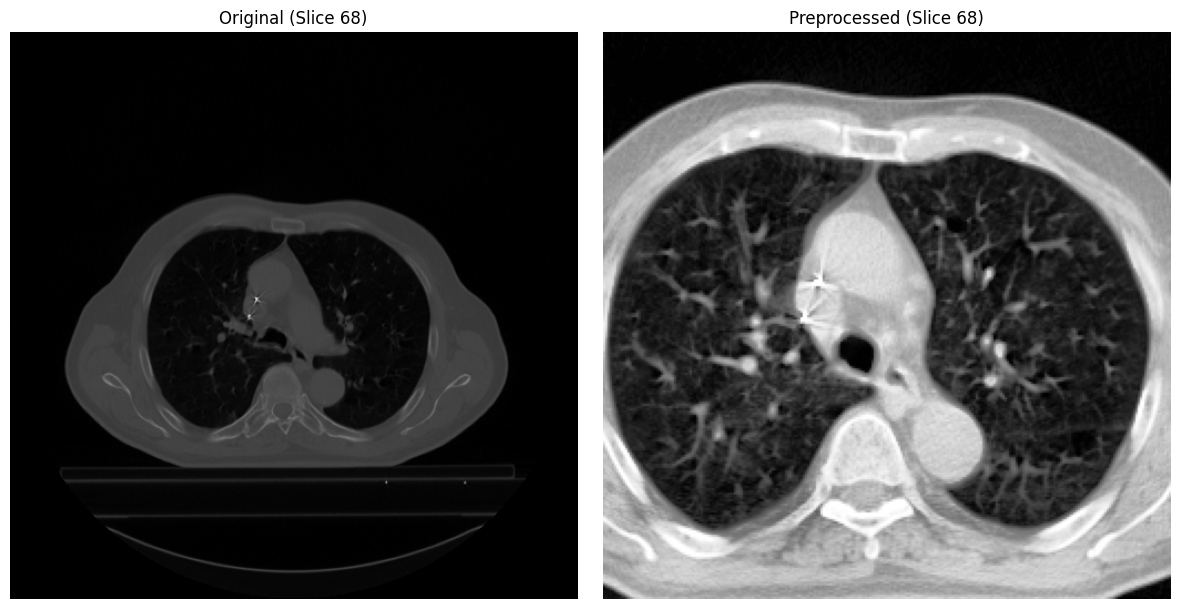

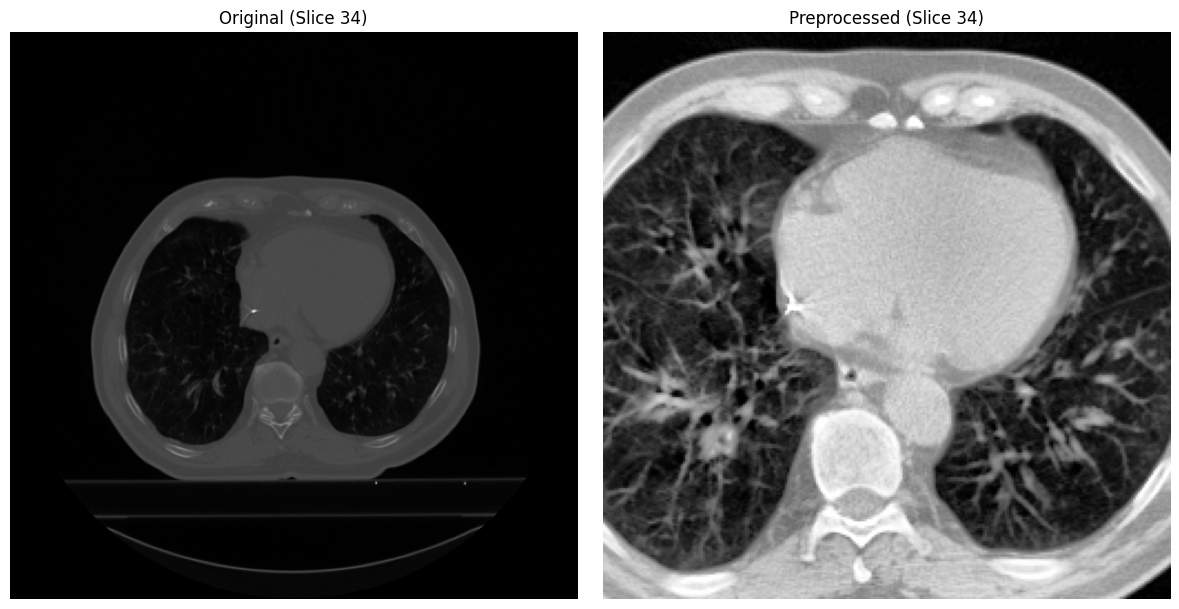

In [6]:
# Visualize original vs preprocessed CT scan
visualize_preprocessing(ct_scan, preprocessed_ct)

# Visualize a different slice
visualize_preprocessing(ct_scan, preprocessed_ct, slice_idx=ct_scan.shape[0]//4)

## **Mask Preprocessing**

Now we need to preprocess the segmentation mask to match the preprocessed CT scan. For masks, we use nearest-neighbor interpolation to preserve the binary nature of the segmentation.

In [7]:
# Preprocess the mask to match the CT scan
# First, resample to the same spacing
resampled_mask, _ = resample_volume(aligned_mask, original_spacing, target_spacing)
print(f"After resampling: {resampled_mask.shape}")

# Then resize to the target shape
preprocessed_mask = center_crop_or_pad(resampled_mask, target_shape)
print(f"After resizing: {preprocessed_mask.shape}")

# Ensure mask is binary
preprocessed_mask = (preprocessed_mask > 0.5).astype(np.uint8)

# Display information about the preprocessed mask
print("\nPreprocessed Mask Information:")
print(f"Shape: {preprocessed_mask.shape}")
print(f"Data type: {preprocessed_mask.dtype}")
print(f"Unique values: {np.unique(preprocessed_mask)}")

After resampling: (133, 500, 500)
After resizing: (128, 256, 256)

Preprocessed Mask Information:
Shape: (128, 256, 256)
Data type: uint8
Unique values: [0 1]


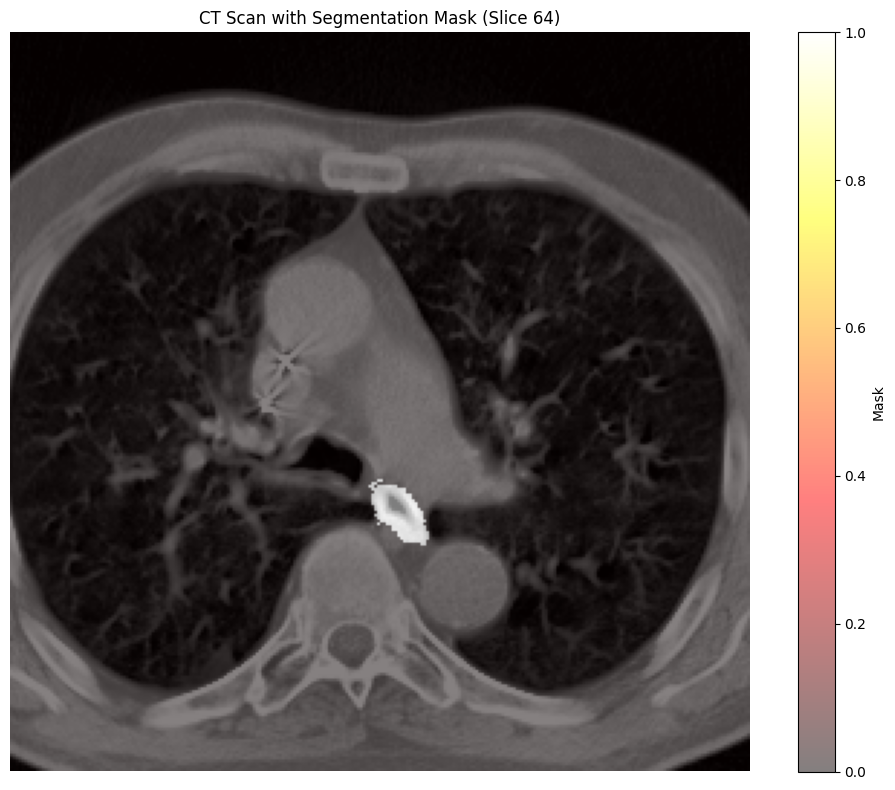

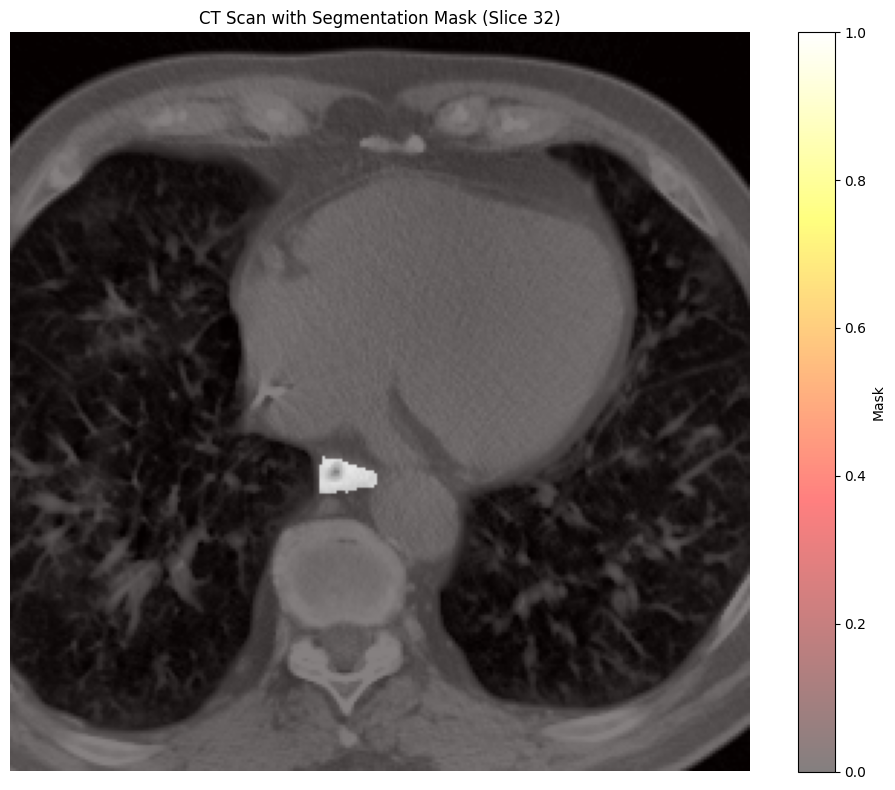

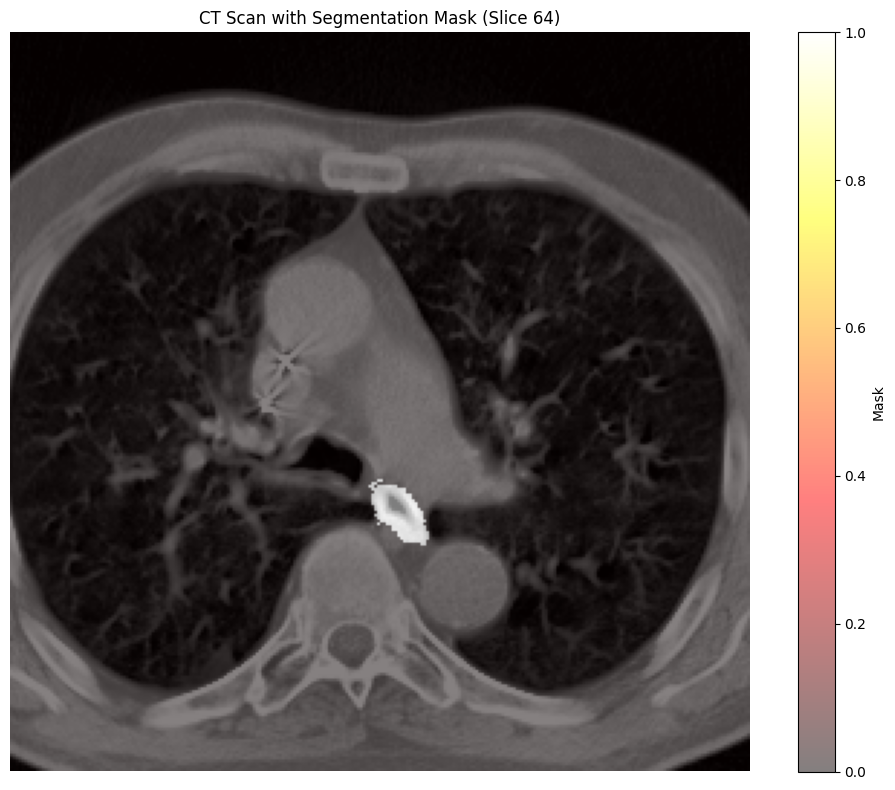

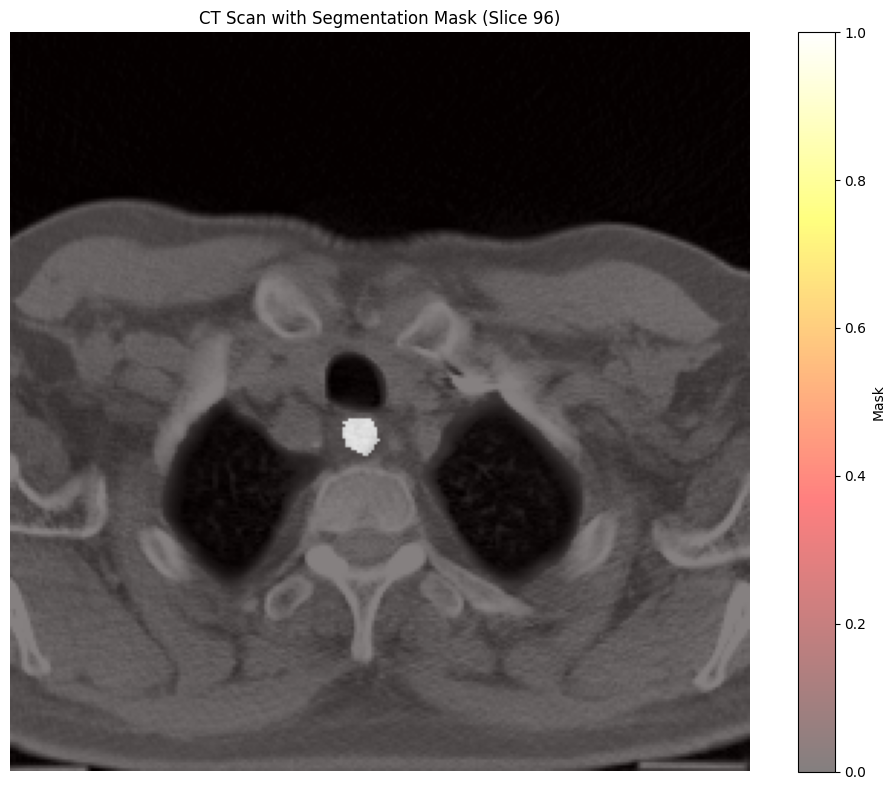

In [8]:
# Visualize the preprocessed CT scan with the mask overlay
def plot_ct_with_mask_overlay(ct, mask, slice_idx=None):
    """Plot a CT scan slice with a segmentation mask overlay"""
    if slice_idx is None:
        slice_idx = ct.shape[0] // 2
    
    plt.figure(figsize=(10, 8))
    plt.imshow(ct[slice_idx], cmap='gray')
    plt.imshow(mask[slice_idx], alpha=0.5, cmap='hot')
    plt.title(f"CT Scan with Segmentation Mask (Slice {slice_idx})")
    plt.axis('off')
    plt.colorbar(label='Mask')
    plt.tight_layout()
    plt.show()

# Visualize middle slice
plot_ct_with_mask_overlay(preprocessed_ct, preprocessed_mask)

# Visualize a few more slices
for i in range(3):
    slice_idx = preprocessed_ct.shape[0] // 4 * (i + 1)
    plot_ct_with_mask_overlay(preprocessed_ct, preprocessed_mask, slice_idx)

## **Batch Preprocessing Function**

Here's a function to preprocess multiple patients in batch mode.

In [9]:
def batch_preprocess_patients(base_dir, output_dir, patient_ids=None, 
                             target_spacing=[1.0, 1.0, 1.0], target_shape=(128, 256, 256)):
    """Preprocess multiple patients in batch mode"""
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # If no patient IDs provided, process all patients in the base directory
    if patient_ids is None:
        patient_ids = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d.startswith('LUNG')]
    
    print(f"Found {len(patient_ids)} patients to process")
    
    # Process each patient
    for patient_id in patient_ids:
        try:
            print(f"\nProcessing patient {patient_id}...")
            
            # Find paths
            ct_dir, mask_path = find_patient_data_paths(base_dir, patient_id)
            
            if ct_dir is None or mask_path is None:
                print(f"Skipping patient {patient_id}: Missing CT or mask")
                continue
            
            # Load CT scan using our safe loading function
            try:
                # Use the new safe loading function that checks for PixelData
                ct_scan, valid_dicom_datasets, spacing = load_dicom_series_safely(ct_dir)
                original_spacing = spacing
            except Exception as e:
                print(f"Error loading CT scan for patient {patient_id}: {e}")
                continue
            
            # Load and align mask
            try:
                mask = pydicom.dcmread(mask_path)
                # Check if mask has pixel data
                if not hasattr(mask, 'PixelData') or mask.PixelData is None:
                    print(f"Skipping patient {patient_id}: Mask has no pixel data")
                    continue
                    
                mask_data = mask.pixel_array
                
                # Get Z positions from valid DICOM datasets
                ct_z_positions = [float(ds.ImagePositionPatient[2]) for ds in valid_dicom_datasets if hasattr(ds, 'ImagePositionPatient')]
                
                mask_z_positions = []
                for item in mask.PerFrameFunctionalGroupsSequence:
                    if hasattr(item, 'PlanePositionSequence') and hasattr(item.PlanePositionSequence[0], 'ImagePositionPatient'):
                        z = float(item.PlanePositionSequence[0].ImagePositionPatient[2])
                        mask_z_positions.append(z)
                
                if not mask_z_positions or not ct_z_positions:
                    print(f"Skipping patient {patient_id}: Missing position information")
                    continue
                
                # Align mask to CT
                aligned_mask_slices = []
                for ct_z in ct_z_positions:
                    mask_idx = np.argmin(np.abs(np.array(mask_z_positions) - ct_z))
                    aligned_mask_slices.append(mask_data[mask_idx])
                
                aligned_mask = np.stack(aligned_mask_slices)
            except Exception as e:
                print(f"Error processing mask for patient {patient_id}: {e}")
                continue
            
            # Preprocess CT scan
            preprocessed_ct = preprocess_ct_scan(
                ct_scan=ct_scan,
                spacing=original_spacing,
                target_spacing=target_spacing,
                target_shape=target_shape,
                normalize=True,
                enhance=True
            )
            
            # Preprocess mask
            resampled_mask, _ = resample_volume(aligned_mask, original_spacing, target_spacing)
            preprocessed_mask = center_crop_or_pad(resampled_mask, target_shape)
            preprocessed_mask = (preprocessed_mask > 0.5).astype(np.uint8)
            
        
            print(f"Successfully processed patient {patient_id}")
            
        except Exception as e:
            print(f"Error processing patient {patient_id}: {e}")
    
    print("\nBatch preprocessing complete!")

In [10]:
# Example usage of batch preprocessing (commented out to avoid accidental execution)
batch_preprocess_patients(
     base_dir="E:/cancer stage/NSCLC-Radiomics",
     output_dir="preprocessed_data",
     patient_ids=["LUNG1-098", "LUNG1-080"],  # Process specific patients
     target_spacing=[1.0, 1.0, 1.0],
     target_shape=(128, 256, 256)
)

Found 2 patients to process

Processing patient LUNG1-098...
Loading DICOM series from E:/cancer stage/NSCLC-Radiomics\LUNG1-098\03-03-2006-StudyID-NA-35118\1.000000-NA-40914...
Found 1 DICOM files
Sorting slices by InstanceNumber...
Reading DICOM slices...


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

Error loading CT scan for patient LUNG1-098: No valid DICOM files with pixel data found

Processing patient LUNG1-080...
Loading DICOM series from E:/cancer stage/NSCLC-Radiomics\LUNG1-080\12-31-2005-StudyID-NA-96786\1.000000-NA-07599...
Found 1 DICOM files
Sorting slices by InstanceNumber...


Reading DICOM slices...


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

Error loading CT scan for patient LUNG1-080: No valid DICOM files with pixel data found

Batch preprocessing complete!


## **Enhanced Batch Preprocessing with Data Augmentation**

Let's create an enhanced version of our batch preprocessing function that includes data augmentation capabilities.

In [11]:
def batch_preprocess_with_augmentation(base_dir, output_dir, patient_ids=None, 
                                      target_spacing=[1.0, 1.0, 1.0], target_shape=(128, 256, 256),
                                      augmentation_count=5, augmentation_types=None):
    """
    Preprocess multiple patients in batch mode with data augmentation
    
    Args:
        base_dir: Base directory containing patient data
        output_dir: Directory to save preprocessed data
        patient_ids: List of patient IDs to process (if None, process all)
        target_spacing: Target voxel spacing in mm
        target_shape: Target volume shape
        augmentation_count: Number of augmented copies to create per patient
        augmentation_types: List of augmentation types to apply (if None, use all available types)
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # If no patient IDs provided, process all patients in the base directory
    if patient_ids is None:
        patient_ids = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d.startswith('LUNG')]
    
    print(f"Found {len(patient_ids)} patients to process")
    
    # Process each patient
    for patient_id in patient_ids:
        try:
            print(f"\nProcessing patient {patient_id}...")
            
            # Find paths
            ct_dir, mask_path = find_patient_data_paths(base_dir, patient_id)
            
            if ct_dir is None or mask_path is None:
                print(f"Skipping patient {patient_id}: Missing CT or mask")
                continue
            
            # Load CT scan using our safe loading function
            try:
                # Use the new safe loading function that checks for PixelData
                ct_scan, valid_dicom_datasets, spacing = load_dicom_series_safely(ct_dir)
                original_spacing = spacing
            except Exception as e:
                print(f"Error loading CT scan for patient {patient_id}: {e}")
                continue
            
            # Load and align mask
            try:
                mask = pydicom.dcmread(mask_path)
                # Check if mask has pixel data
                if not hasattr(mask, 'PixelData') or mask.PixelData is None:
                    print(f"Skipping patient {patient_id}: Mask has no pixel data")
                    continue
                    
                mask_data = mask.pixel_array
                
                # Get Z positions from valid DICOM datasets
                ct_z_positions = [float(ds.ImagePositionPatient[2]) for ds in valid_dicom_datasets if hasattr(ds, 'ImagePositionPatient')]
                
                mask_z_positions = []
                for item in mask.PerFrameFunctionalGroupsSequence:
                    if hasattr(item, 'PlanePositionSequence') and hasattr(item.PlanePositionSequence[0], 'ImagePositionPatient'):
                        z = float(item.PlanePositionSequence[0].ImagePositionPatient[2])
                        mask_z_positions.append(z)
                
                if not mask_z_positions or not ct_z_positions:
                    print(f"Skipping patient {patient_id}: Missing position information")
                    continue
                
                # Align mask to CT
                aligned_mask_slices = []
                for ct_z in ct_z_positions:
                    mask_idx = np.argmin(np.abs(np.array(mask_z_positions) - ct_z))
                    aligned_mask_slices.append(mask_data[mask_idx])
                
                aligned_mask = np.stack(aligned_mask_slices)
            except Exception as e:
                print(f"Error processing mask for patient {patient_id}: {e}")
                continue
            
            # Preprocess CT scan
            preprocessed_ct = preprocess_ct_scan(
                ct_scan=ct_scan,
                spacing=original_spacing,
                target_spacing=target_spacing,
                target_shape=target_shape,
                normalize=True,
                enhance=True
            )
            
            # Preprocess mask
            resampled_mask, _ = resample_volume(aligned_mask, original_spacing, target_spacing)
            preprocessed_mask = center_crop_or_pad(resampled_mask, target_shape)
            preprocessed_mask = (preprocessed_mask > 0.5).astype(np.uint8)
            
            # Create patient output directory
            patient_output_dir = os.path.join(output_dir, patient_id)
            os.makedirs(patient_output_dir, exist_ok=True)
            
            # Save original preprocessed data
            np.save(os.path.join(patient_output_dir, 'ct_scan.npy'), preprocessed_ct)
            np.save(os.path.join(patient_output_dir, 'mask.npy'), preprocessed_mask)
            
            # Apply data augmentation
            if augmentation_count > 0:
                print(f"Generating {augmentation_count} augmented samples for patient {patient_id}...")
                
                # Create augmentation directory
                aug_dir = os.path.join(patient_output_dir, 'augmentations')
                os.makedirs(aug_dir, exist_ok=True)
                
                # Generate augmented samples
                for i in range(augmentation_count):
                    # Set random seed for reproducibility and to ensure CT and mask get the same transformations
                    random_seed = i + hash(patient_id) % 10000
                    np.random.seed(random_seed)
                    
                    # Augment CT scan
                    augmented_ct = augment_ct_scan(preprocessed_ct, augmentation_types)
                    
                    # For masks, we use only spatial transformations (not intensity-based ones)
                    mask_aug_types = ['rotation', 'shift', 'flip', 'zoom'] if augmentation_types is None else [
                        t for t in augmentation_types if t in ['rotation', 'shift', 'flip', 'zoom']
                    ]
                    
                    # Apply same transformations to mask
                    np.random.seed(random_seed)  # Use same seed for mask to get identical transformations
                    augmented_mask = augment_ct_scan(preprocessed_mask.astype(float), mask_aug_types)
                    
                    # Reset random seed
                    np.random.seed(None)
                    
                    # Ensure mask remains binary
                    augmented_mask = (augmented_mask > 0.5).astype(np.uint8)
                    
                    # Save augmented data
                    np.save(os.path.join(aug_dir, f'ct_scan_aug_{i}.npy'), augmented_ct)
                    np.save(os.path.join(aug_dir, f'mask_aug_{i}.npy'), augmented_mask)
                
                print(f"Successfully generated {augmentation_count} augmented samples")
            
            print(f"Successfully processed patient {patient_id}")
            
        except Exception as e:
            print(f"Error processing patient {patient_id}: {e}")
    
    print("\nBatch preprocessing with augmentation complete!")

## **CT Augmentation**

In [12]:
def create_ct_data_generator(data_dir, batch_size=8, augment=True, augmentation_types=None, shuffle=True):
    """
    Create a generator that yields batches of CT scans and masks for training.
    
    Args:
        data_dir: Directory containing preprocessed patient data
        batch_size: Number of samples per batch
        augment: Whether to apply augmentation
        augmentation_types: List of augmentation types to apply
        shuffle: Whether to shuffle the data
        
    Yields:
        Tuple of (ct_batch, mask_batch) where each is a numpy array of shape [batch_size, depth, height, width]
    """
    # Find all patient directories
    patient_dirs = [os.path.join(data_dir, d) for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    
    print(f"Found {len(patient_dirs)} patients in {data_dir}")
    
    # Create a list of all available samples (original and augmented)
    samples = []
    
    for patient_dir in patient_dirs:
        # Add original sample
        ct_path = os.path.join(patient_dir, 'ct_scan.npy')
        mask_path = os.path.join(patient_dir, 'mask.npy')
        
        if os.path.exists(ct_path) and os.path.exists(mask_path):
            samples.append((ct_path, mask_path))
        
        # Add augmented samples if they exist
        aug_dir = os.path.join(patient_dir, 'augmentations')
        if os.path.exists(aug_dir):
            aug_ct_files = [f for f in os.listdir(aug_dir) if f.startswith('ct_scan_aug_') and f.endswith('.npy')]
            
            for aug_ct_file in aug_ct_files:
                aug_idx = aug_ct_file.split('_')[-1].split('.')[0]  # Extract index from filename
                aug_mask_file = f'mask_aug_{aug_idx}.npy'
                
                aug_ct_path = os.path.join(aug_dir, aug_ct_file)
                aug_mask_path = os.path.join(aug_dir, aug_mask_file)
                
                if os.path.exists(aug_ct_path) and os.path.exists(aug_mask_path):
                    samples.append((aug_ct_path, aug_mask_path))
    
    print(f"Found {len(samples)} total samples (original + augmented)")
    
    # Generator function
    def generator():
        while True:
            # Shuffle samples if requested
            if shuffle:
                np.random.shuffle(samples)
            
            # Process samples in batches
            for i in range(0, len(samples), batch_size):
                batch_samples = samples[i:i+batch_size]
                
                # Initialize batch arrays
                # Load first sample to get dimensions
                first_ct = np.load(batch_samples[0][0])
                first_mask = np.load(batch_samples[0][1])
                
                ct_batch = np.zeros((len(batch_samples),) + first_ct.shape, dtype=first_ct.dtype)
                mask_batch = np.zeros((len(batch_samples),) + first_mask.shape, dtype=first_mask.dtype)
                
                # Load samples into batch
                for j, (ct_path, mask_path) in enumerate(batch_samples):
                    ct = np.load(ct_path)
                    mask = np.load(mask_path)
                    
                    # Apply on-the-fly augmentation if requested
                    if augment and np.random.random() < 0.5:  # 50% chance of augmentation
                        # Set random seed for reproducibility
                        random_seed = np.random.randint(0, 10000)
                        np.random.seed(random_seed)
                        
                        # Augment CT
                        ct = augment_ct_scan(ct, augmentation_types)
                        
                        # For masks, only use spatial transformations
                        mask_aug_types = ['rotation', 'shift', 'flip', 'zoom'] if augmentation_types is None else [
                            t for t in augmentation_types if t in ['rotation', 'shift', 'flip', 'zoom']
                        ]
                        
                        # Apply same spatial transformations to mask
                        np.random.seed(random_seed)
                        mask = augment_ct_scan(mask.astype(float), mask_aug_types)
                        mask = (mask > 0.5).astype(np.uint8)
                        
                        # Reset random seed
                        np.random.seed(None)
                    
                    ct_batch[j] = ct
                    mask_batch[j] = mask
                
                yield ct_batch, mask_batch
                
                # If we've processed all samples, and shuffle is False, stop
                if i + batch_size >= len(samples) and not shuffle:
                    break
    
    return generator(), len(samples)

In [13]:
def integrated_ct_augmentation_workflow(base_dir, output_dir, patient_ids=None, 
                                       target_spacing=[1.0, 1.0, 1.0], target_shape=(128, 256, 256),
                                       augmentation_count=5, augmentation_types=None,
                                       visualize=True, create_generator=True):
    """
    Integrated workflow for CT scan preprocessing and augmentation.
    
    This function provides a complete end-to-end workflow:
    1. Load and preprocess CT scans and masks
    2. Apply augmentations to increase dataset size
    3. Optionally visualize the augmentation effects
    4. Optionally create a data generator for model training
    
    Args:
        base_dir: Base directory containing patient data
        output_dir: Directory to save preprocessed data
        patient_ids: List of patient IDs to process (if None, process all)
        target_spacing: Target voxel spacing in mm
        target_shape: Target volume shape
        augmentation_count: Number of augmented copies to create per patient
        augmentation_types: List of augmentation types to apply
        visualize: Whether to visualize sample augmentations
        create_generator: Whether to create and return a data generator
        
    Returns:
        If create_generator is True, returns a tuple of (generator, num_samples)
        Otherwise, returns None
    """
    # Step 1: Preprocess and augment data
    print("Step 1: Preprocessing and augmenting data...")
    batch_preprocess_with_augmentation(
        base_dir=base_dir,
        output_dir=output_dir,
        patient_ids=patient_ids,
        target_spacing=target_spacing,
        target_shape=target_shape,
        augmentation_count=augmentation_count,
        augmentation_types=augmentation_types
    )
    
    # Step 2: Visualize augmentations if requested
    if visualize:
        print("\nStep 2: Visualizing augmentation effects...")
        
        # Find a processed patient to visualize
        patient_dirs = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d))]
        
        if patient_dirs:
            # Use the first patient
            patient_dir = os.path.join(output_dir, patient_dirs[0])
            
            # Load CT and mask
            ct_path = os.path.join(patient_dir, 'ct_scan.npy')
            mask_path = os.path.join(patient_dir, 'mask.npy')
            
            if os.path.exists(ct_path) and os.path.exists(mask_path):
                ct = np.load(ct_path)
                mask = np.load(mask_path)
                
                # Visualize augmentation effects
                print(f"Visualizing augmentation effects for patient {patient_dirs[0]}...")
                visualize_augmentation_effects(ct, mask, n_augmentations=4)
            else:
                print("Could not find CT or mask files for visualization.")
        else:
            print("No processed patients found for visualization.")
    
    # Step 3: Create data generator if requested
    if create_generator:
        print("\nStep 3: Creating data generator...")
        generator, num_samples = create_ct_data_generator(
            data_dir=output_dir,
            batch_size=8,
            augment=True,
            augmentation_types=augmentation_types,
            shuffle=True
        )
        
        print(f"Created data generator with {num_samples} samples.")
        return generator, num_samples
    
    return None

In [14]:
# Example usage of the integrated workflow
# This is commented out to avoid accidental execution

generator, num_samples = integrated_ct_augmentation_workflow(
base_dir="E:/cancer stage/NSCLC-Radiomics",
output_dir="preprocessed_data_integrated",
patient_ids=["LUNG1-098", "LUNG1-080"],  # Process specific patients
target_spacing=[1.0, 1.0, 1.0],
target_shape=(128, 256, 256),
augmentation_count=3,  # Generate 3 augmented copies per patient
augmentation_types=['rotation', 'flip', 'zoom', 'noise', 'contrast'],  # Specify augmentation types
visualize=True,
create_generator=True
)

# # Get a batch from the generator
ct_batch, mask_batch = next(generator)
print(f"Batch shapes: CT {ct_batch.shape}, Mask {mask_batch.shape}")

# # Visualize a sample from the batch
sample_idx = 0
slice_idx = ct_batch.shape[1] // 2  # Middle slice

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ct_batch[sample_idx, slice_idx], cmap='gray')
plt.title('CT Scan')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ct_batch[sample_idx, slice_idx], cmap='gray')
plt.imshow(mask_batch[sample_idx, slice_idx], alpha=0.5, cmap='hot')
plt.title('CT with Mask Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()

Step 1: Preprocessing and augmenting data...
Found 2 patients to process

Processing patient LUNG1-098...
Loading DICOM series from E:/cancer stage/NSCLC-Radiomics\LUNG1-098\03-03-2006-StudyID-NA-35118\1.000000-NA-40914...
Found 1 DICOM files
Sorting slices by InstanceNumber...
Reading DICOM slices...


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

Error loading CT scan for patient LUNG1-098: No valid DICOM files with pixel data found

Processing patient LUNG1-080...
Loading DICOM series from E:/cancer stage/NSCLC-Radiomics\LUNG1-080\12-31-2005-StudyID-NA-96786\1.000000-NA-07599...
Found 1 DICOM files


Sorting slices by InstanceNumber...
Reading DICOM slices...


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

Error loading CT scan for patient LUNG1-080: No valid DICOM files with pixel data found

Batch preprocessing with augmentation complete!

Step 2: Visualizing augmentation effects...
No processed patients found for visualization.

Step 3: Creating data generator...
Found 0 patients in preprocessed_data_integrated
Found 0 total samples (original + augmented)
Created data generator with 0 samples.


KeyboardInterrupt: 

## **Testing Augmentation Functions**

Let's test our augmentation functions on a sample CT scan to see the effects of different augmentation types.

Testing augmentation on preprocessed CT scan and mask...


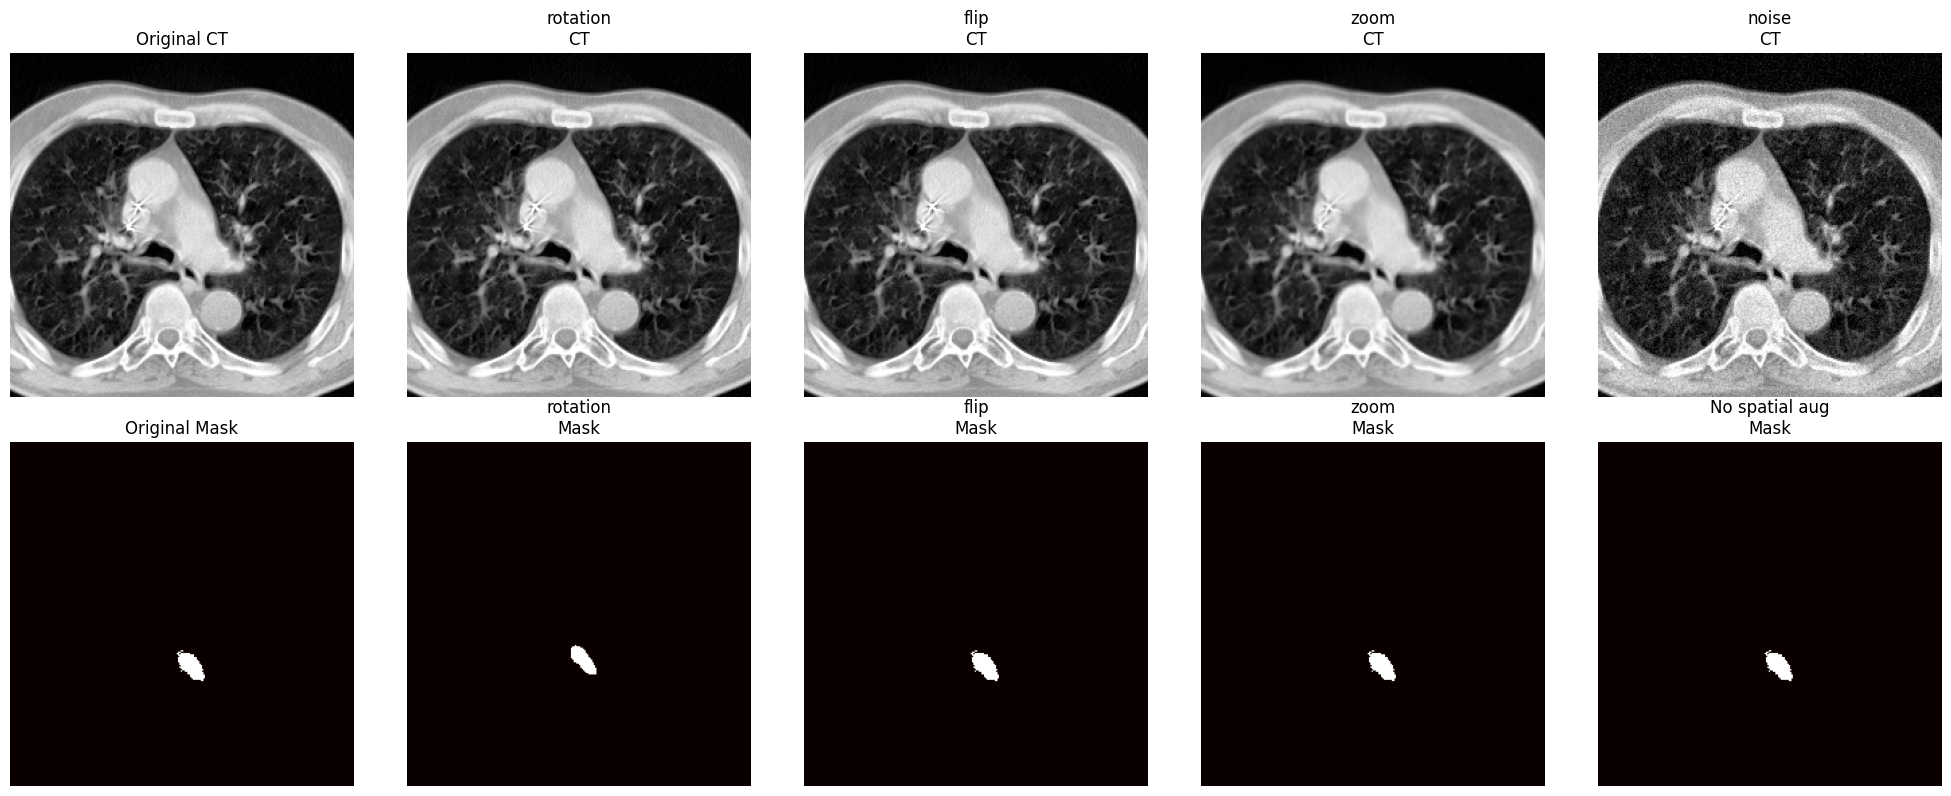

In [15]:
# Test augmentation on the current preprocessed CT scan and mask (if available)
if 'preprocessed_ct' in locals() and 'preprocessed_mask' in locals():
    print("Testing augmentation on preprocessed CT scan and mask...")
    visualize_augmentation_effects(preprocessed_ct, preprocessed_mask, n_augmentations=4)
else:
    print("No preprocessed CT scan and mask available. Please run the preprocessing cells first.")

In [ ]:
def main(data_dir="preprocessed_data_integrated",
         csv_path="E:/cancer stage/lung_csv.csv",
         patch_size=(64, 64, 64),
         batch_size=8,
         num_epochs=50,
         patience=10,
         learning_rate=0.001,
         weight_decay=1e-4,
         model_save_path="resnet18_3d_cancer_stage.pth"):
    """
    Main function to run the cancer stage classification pipeline

    Args:
        data_dir: Directory with preprocessed data
        csv_path: Path to CSV with labels
        patch_size: Size of patches to extract
        batch_size: Batch size
        num_epochs: Maximum number of epochs
        patience: Patience for early stopping
        learning_rate: Initial learning rate
        weight_decay: Weight decay for regularization
        model_save_path: Path to save the trained model
    """
    print("=" * 80)
    print("CANCER STAGE CLASSIFICATION USING 3D RESNET")
    print("=" * 80)

    # Set random seeds for reproducibility
    set_seed(42)

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create datasets and dataloaders
    train_dataset = CTScanDataset(
        data_dir=data_dir,
        csv_path=csv_path,
        patch_size=patch_size,
        mode='train'
    )

    val_dataset = CTScanDataset(
        data_dir=data_dir,
        csv_path=csv_path,
        patch_size=patch_size,
        mode='val'
    )

    test_dataset = CTScanDataset(
        data_dir=data_dir,
        csv_path=csv_path,
        patch_size=patch_size,
        mode='test'
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Create model
    model = ResNet18_3D(num_classes=4)
    model = model.to(device)

    # Define loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=train_dataset.class_weights.to(device))

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Define learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Train model
    print("Starting training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=num_epochs,
        patience=patience
    )

    # Save trained model
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to '{model_save_path}'")

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    print("Evaluating model on test set...")
    test_loss, test_acc, all_preds, all_labels = evaluate_model(
        model=model,
        test_loader=test_loader,
        criterion=criterion,
        device=device
    )

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Plot confusion matrix
    class_names = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
    plot_confusion_matrix(all_labels, all_preds, class_names)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))